In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from yellowbrick.model_selection import learning_curve


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

# Loading and saving images as .npy files so we could deal with them

In [2]:
code = {'basal cell carcinoma':0, 'melanoma':1, 'pigmented benign keratosis':2}
#function to return the class of the images from its number.
def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

In [3]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [4]:
#the directory that contain the train images set
trainpath='/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Untitled folder/Train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) :
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#the directory that contain the test images set
testpath='/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Untitled folder/Test/'
X_test = []
y_test = []
for folder in  os.listdir(testpath) :
    files = gb.glob(pathname= str( testpath + folder + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

The .npy files are then uploaded to Google Drive

# Loading the .npy files as numpy arrays

In [7]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image
loaded_X_train = np.load('./X_train.npy')
loaded_X_test = np.load('./X_test.npy')
loaded_y_train = np.load('./y_train.npy')
loaded_y_test = np.load('./y_test.npy')

In [8]:
print(loaded_X_train.shape)
#the shape return dimensions of X_train, we have 1276 images of 64 x 64 pixels.
#while the forth dimension stores the RGB information of each pixel

(1276, 64, 64, 3)


In [9]:
print(loaded_X_test.shape)

(48, 64, 64, 3)


In [10]:
#y_train and y_test contain the labels of each image
print(loaded_y_train.shape)
print(loaded_y_test.shape)

(1276,)
(48,)


# Data Analysis

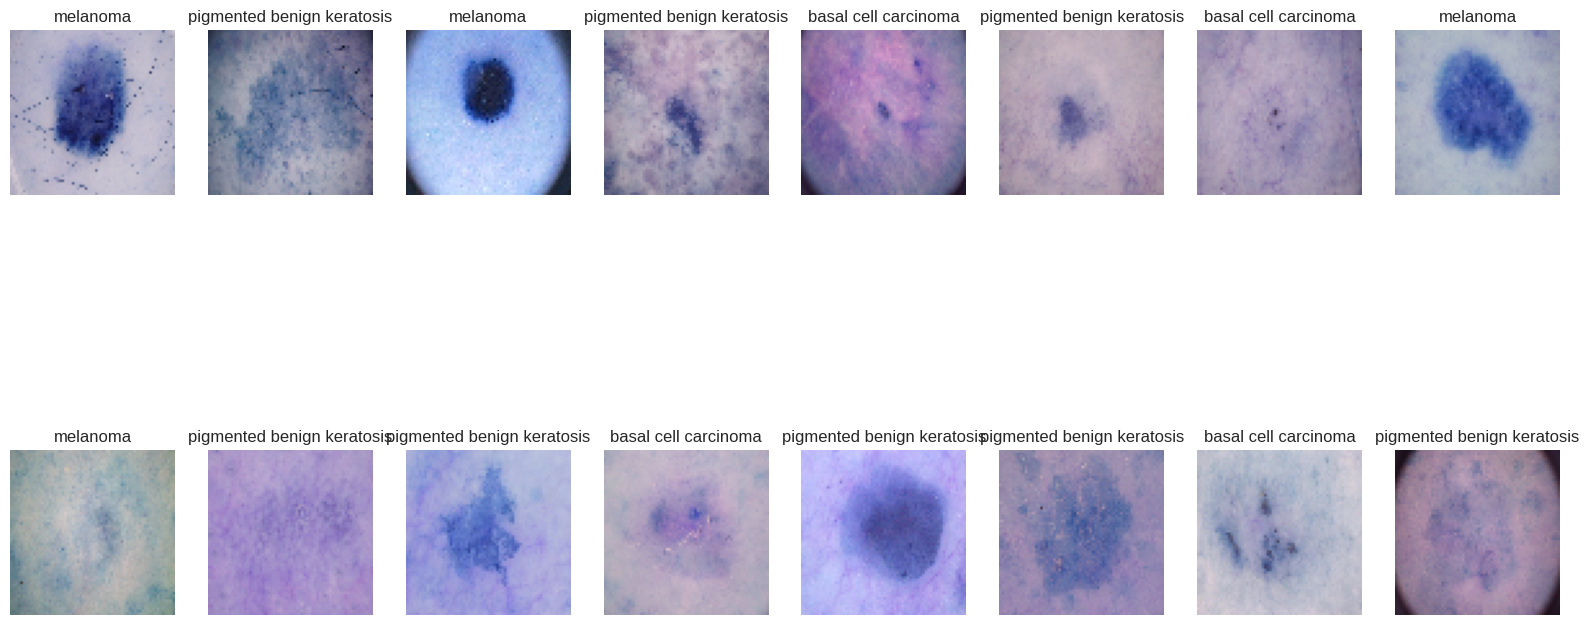

In [11]:
#plotting images
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)):
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i])
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

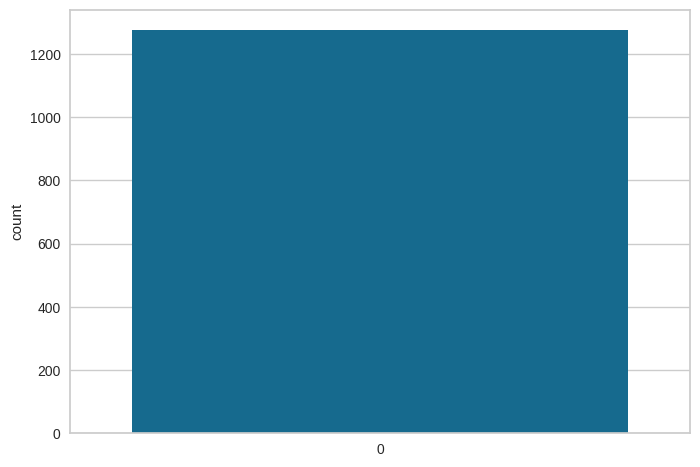

In [12]:
#count plot to show the number of skin cancer cases to normal cases in the train data set
df_train = pd.DataFrame()
df_train["labels"]= loaded_y_train
lab = df_train['labels']
dist = lab.value_counts()
sns.countplot(lab)
plt.show()

As we can see skin cancer cases are over represented in the train data set. We will deal with such imbalance later

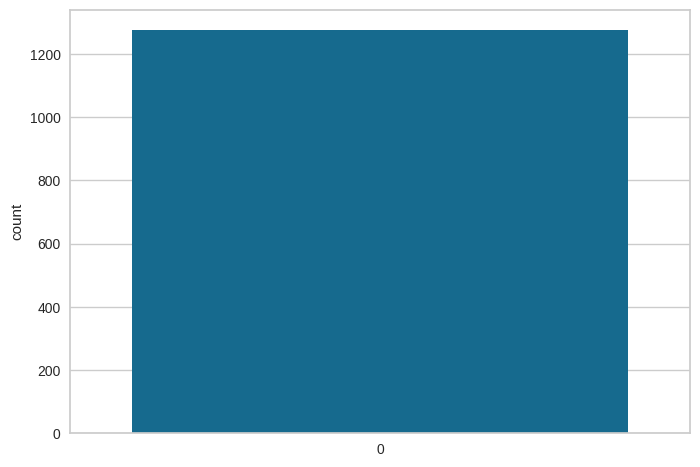

In [13]:
#count plot to show the number of skin cancer cases to normal cases in the test data set

df_test = pd.DataFrame()
df_test["labels"]= loaded_y_test
lab = df_test['labels']
dist = lab.value_counts()
#play with pallette colors
sns.countplot(df_train['labels'])
plt.show()

In [14]:
#function to plot the pixel intensity of each image.
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)

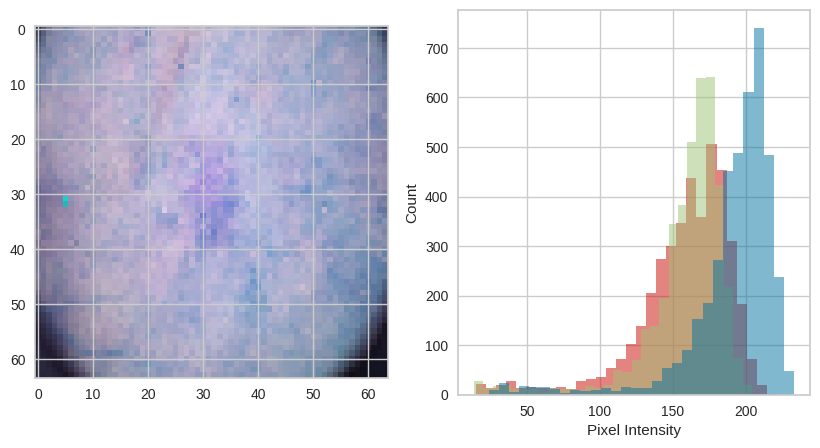

In [15]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

Flatten and shuffle train and test sets

In [16]:
#flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((64,64,3))])
X_test = loaded_X_test.reshape([-1, np.product((64,64,3))])

In [17]:
print(X_train.shape)
print(X_test.shape)

(1276, 12288)
(48, 12288)


In [18]:
y_train = loaded_y_train
y_test = loaded_y_test

In [19]:
#shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

# Data Preprocessing

In [20]:
#Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

we will use Principle Component Analysis (PCA) to reduce the amount of features, to n number of components that represent 0.95% variance of data  

In [21]:
#PCA
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [22]:
#printing the variance of each component from PCA
print('Number of components after PCA: ' + str(pca.n_components_))

Number of components after PCA: 189


# Testing classification algorithms after scaling and PCA

In [23]:
#making an instance for each algorithm
knn_PCA = KNeighborsClassifier(n_neighbors=3)
log_reg_PCA  = LogisticRegression()
dtc_PCA  = DecisionTreeClassifier()
rfc_PCA = RandomForestClassifier()
svm_PCA = SVC()

In [24]:
# fitting each model using X_train and y_train
knn_PCA.fit(X_train, y_train)
log_reg_PCA.fit(X_train, y_train)
dtc_PCA.fit(X_train, y_train)
rfc_PCA.fit(X_train, y_train)
svm_PCA.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC()

In [25]:
#scoring each model
print('KNN accuracy score is: ' + str(knn_PCA.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg_PCA.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc_PCA.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc_PCA.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm_PCA.score(X_test, y_test)))

KNN accuracy score is: 0.5416666666666666
Logistic Regression accuracy score is: 0.625
Decision Tree Classifier accuracy score is: 0.6041666666666666
Random forests Classifier accuracy score is: 0.6458333333333334
Support Vector Machine Classifier accuracy score is: 0.6458333333333334


The highest accuracy score obtaiend from the support vector machine. As accuracy score is not enough to judge a model we will use confusion matrix

In [26]:
#making predictions for each model
knn_PCA_predcited = knn_PCA.predict(X_test)
log_reg_PCA_predcited = log_reg_PCA.predict(X_test)
dtc_PCA_predcited = dtc_PCA.predict(X_test)
rfc_PCA_predcited = rfc_PCA.predict(X_test)
svm_PCA_predcited = svm_PCA.predict(X_test)

In [27]:
def plot_cm(predictions, y_test, title, class_labels):
    cm = confusion_matrix(y_test, predictions)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    plt.figure(figsize=(7, 7))
    plt.title(title)

    sns.heatmap(cm, linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=class_labels, yticklabels=class_labels[::-1])

    # Move x-axis ticks to the top
    plt.tick_params(axis='x', which='both', bottom=False, top=True)

    plt.show()

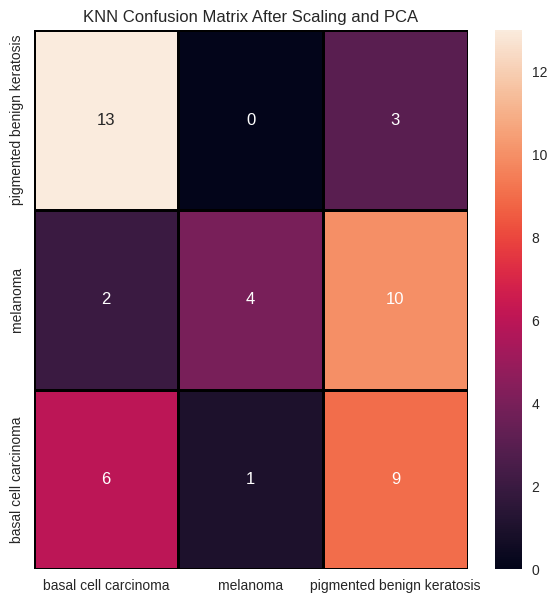

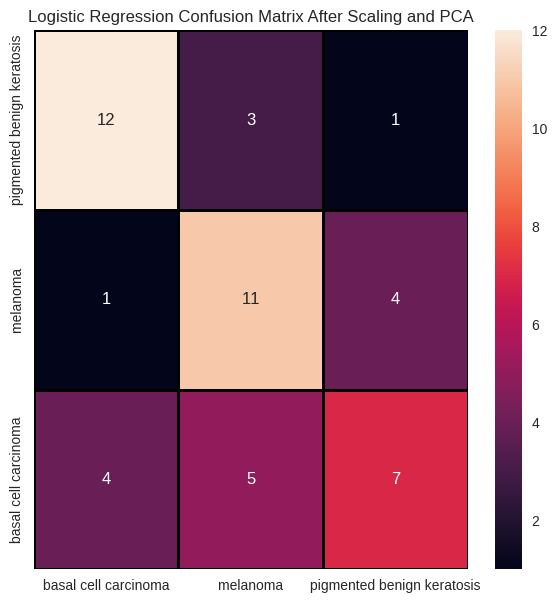

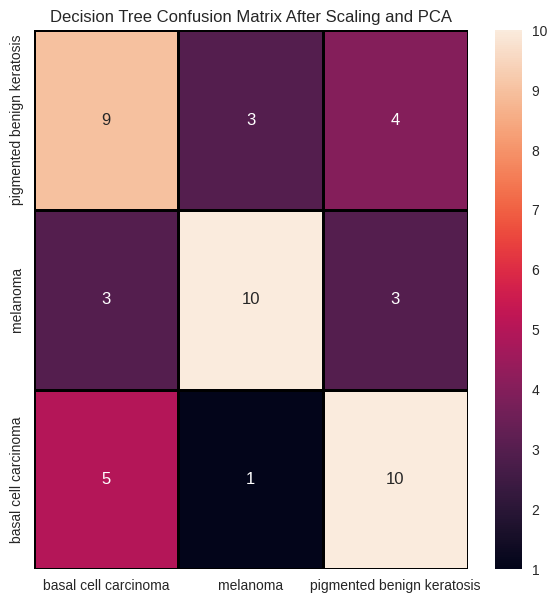

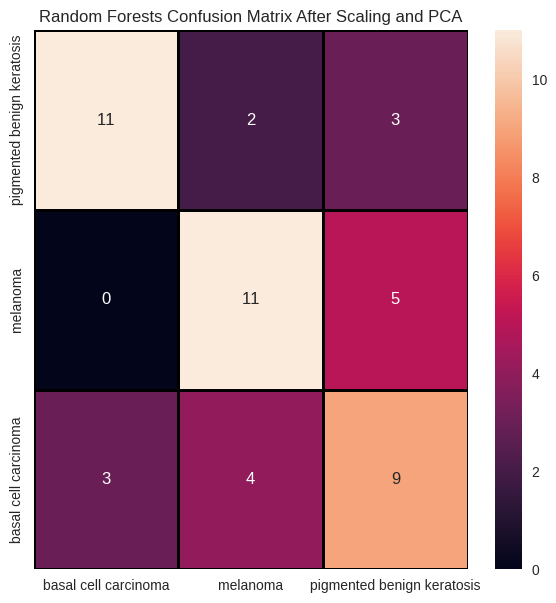

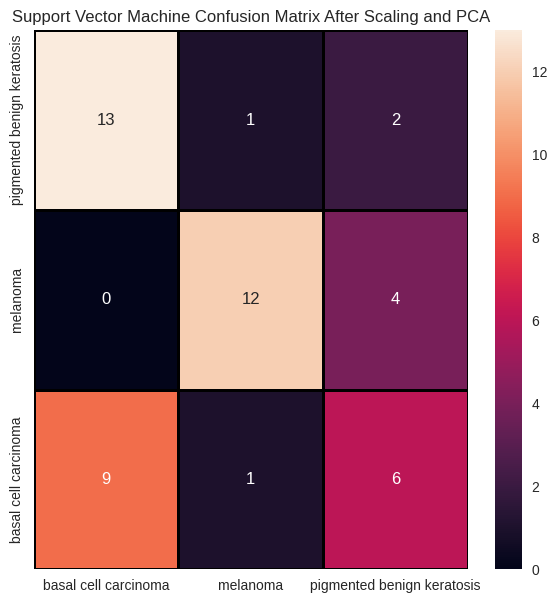

In [28]:
#plot confusion matrix for each model after scaling and PCA
class_labels = ['basal cell carcinoma','melanoma','pigmented benign keratosis']
plot_cm(knn_PCA_predcited, y_test, 'KNN Confusion Matrix After Scaling and PCA',class_labels)

plot_cm(log_reg_PCA_predcited, y_test, 'Logistic Regression Confusion Matrix After Scaling and PCA', class_labels)

plot_cm(dtc_PCA_predcited, y_test, 'Decision Tree Confusion Matrix After Scaling and PCA', class_labels)

plot_cm(rfc_PCA_predcited, y_test, 'Random Forests Confusion Matrix After Scaling and PCA', class_labels)

plot_cm(svm_PCA_predcited, y_test, 'Support Vector Machine Confusion Matrix After Scaling and PCA', class_labels)

In [29]:
import pickle

# Assuming 'rfc_PCA' is your trained Random Forest Classifier model
with open('skin_cancer_model.pkl', 'wb') as model_file:
    pickle.dump(rfc_PCA, model_file)

# Assuming 'sc' is your StandardScaler object
with open('standard_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(sc, scaler_file)

# Assuming 'pca' is your PCA object
with open('pca_transformer.pkl', 'wb') as pca_file:
    pickle.dump(pca, pca_file)
